# 双向循环神经网络
:label:`sec_bi_rnn`

在顺序学习中，到目前为止，我们假定我们的目标是根据我们目前所看到的情况，例如，在时间序列的背景下或在语言模型的背景下，对下一个输出进行建模。虽然这是一个典型的情况，但这并不是我们唯一可能遇到的情况。为了说明这个问题，请考虑以下三项任务，即在文本序列中填写空白：

* 我是 `___`。
* 我是 `___` 饿了。
* 我饿了 `___`，我可以吃半头猪。

根据可用信息的数量，我们可能会用非常不同的词语填写空白，例如 “快乐”、“不” 和 “非常”。显然，短语的末尾（如果可用）传达了关于要选择哪个词的重要信息。无法利用这一点的序列模型在相关任务上的表现不佳。例如，要做好命名实体识别（例如，识别 “绿色” 是指 “绿色先生” 还是指颜色），更长范围的上下文同样至关重要。为了获得解决问题的灵感，让我们绕过概率图形模型。

## 隐藏的马尔可夫模型中的动态编程

本小节用于说明动态编程问题。具体的技术细节对于了解深度学习模型无关紧要，但它们有助于激发人们为什么可能使用深度学习以及为什么可能选择特定的架构。

如果我们想使用概率图形模型来解决问题，我们可以例如设计一个潜在变量模型，如下所示。在任何时候步骤 $t$，我们假设存在一些潜在变量 $h_t$，它控制着我们观察到的 $x_t$ 至 $P(x_t \mid h_t)$ 的排放。此外，任何过渡 $h_t \to h_{t+1}$ 都是由某种状态过渡概率 $P(h_{t+1} \mid h_{t})$ 给出的。然后，这种概率图形模型就是 :numref:`fig_hmm` 中的 * 隐藏的马尔可夫模型 *。

![A hidden Markov model.](../img/hmm.svg)
:label:`fig_hmm`

因此，对于 $T$ 次观测值的序列，我们在观察状态和隐藏状态上有以下联合概率分布：

$$P(x_1, \ldots, x_T, h_1, \ldots, h_T) = \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t), \text{ where } P(h_1 \mid h_0) = P(h_1).$$
:eqlabel:`eq_hmm_jointP`

现在假设我们观察到除了 $x_j$ 之外的所有 $x_i$，我们的目标是计算 $P(x_j \mid x_{-j})$，其中 $x_{-j} = (x_1, \ldots, x_{j-1}, x_{j+1}, \ldots, x_{T})$。由于 $P(x_j \mid x_{-j})$ 中没有潜在变量，我们考虑总结 $h_1, \ldots, h_T$ 的所有可能选择组合。如果任何 $h_i$ 可以接受 $k$ 个不同值（有限数量的状态），这意味着我们需要总和超过 $k^T$ 个术语-通常是不可能的任务！幸运的是，有一个优雅的解决方案：* 动态编程 *。

要了解它是如何工作的，请考虑依次对潜在变量 $h_1, \ldots, h_T$ 进行总结。根据 :eqref:`eq_hmm_jointP`，这种收益率为：

$$\begin{aligned}
    &P(x_1, \ldots, x_T) \\
    =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} P(h_1) P(x_1 \mid h_1) P(h_2 \mid h_1)\right]}_{\pi_2(h_2) \stackrel{\mathrm{def}}{=}}
    P(x_2 \mid h_2) \prod_{t=3}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) P(x_2 \mid h_2) P(h_3 \mid h_2)\right]}_{\pi_3(h_3)\stackrel{\mathrm{def}}{=}}
    P(x_3 \mid h_3) \prod_{t=4}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t)\\
    =& \dots \\
    =& \sum_{h_T} \pi_T(h_T) P(x_T \mid h_T).
\end{aligned}$$

一般来说我们有 * 转发递归 *

$$\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) P(x_t \mid h_t) P(h_{t+1} \mid h_t).$$

递归初始化为 $\pi_1(h_1) = P(h_1)$。抽象地说，这可以写成 $\pi_{t+1} = f(\pi_t, x_t)$，其中 $f$ 是一些可学习的功能。这看起来非常像我们到目前为止在 RNN 上下文中讨论的潜在变量模型中的更新方程式！

完全类似于向前递归，我们还可以用向后递归对同一组潜在变量进行总和。这产生了：

$$\begin{aligned}
    & P(x_1, \ldots, x_T) \\
     =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot P(h_T \mid h_{T-1}) P(x_T \mid h_T) \\
    =& \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} P(h_T \mid h_{T-1}) P(x_T \mid h_T)\right]}_{\rho_{T-1}(h_{T-1})\stackrel{\mathrm{def}}{=}} \\
    =& \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} P(h_{T-1} \mid h_{T-2}) P(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{\rho_{T-2}(h_{T-2})\stackrel{\mathrm{def}}{=}} \\
    =& \ldots \\
    =& \sum_{h_1} P(h_1) P(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{aligned}$$

因此，我们可以将 * 向后递归 * 写为

$$\rho_{t-1}(h_{t-1})= \sum_{h_{t}} P(h_{t} \mid h_{t-1}) P(x_{t} \mid h_{t}) \rho_{t}(h_{t}),$$

初始化 $\rho_T(h_T) = 1$。前向递归和向后递归都允许我们在 $\mathcal{O}(kT)$（线性）时间内对 $(h_1, \ldots, h_T)$ 的所有值进行总和超过 $T$ 个潜在变量，而不是按指数时间。这是使用图形模型进行概率推理的巨大好处之一。这也是一般消息传递算法 :cite:`Aji.McEliece.2000` 的一个非常特殊的实例。结合向前和向后递归，我们能够计算

$$P(x_j \mid x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) P(x_j \mid h_j).$$

请注意，抽象地说，向后递归可以写成 $\rho_{t-1} = g(\rho_t, x_t)$，其中 $g$ 是一个可学习的函数。再次，这看起来非常像一个更新方程式，只是向后运行，不像我们到目前为止在 rnN 中看到的。事实上，隐藏的马尔可夫模型受益于了解未来可用的数据。信号处理科学家区分了解和不知道未来观测作为插值法与外推法的两种情况。有关更多详细信息，请参阅本书中有关连续蒙特卡洛算法的入门章节 :cite:`Doucet.De-Freitas.Gordon.2001`。

## 双向模型

如果我们希望在 RNN 中有一种能够提供与隐藏马尔科夫模型相似的预测能力的机制，我们需要修改迄今为止看到的 RNN 设计。幸运的是，这在概念上很容易。我们不是仅在前进模式下从第一个令牌开始运行 RNN，而是从后一个令牌从后到前运行的最后一个令牌启动另一个令牌。
*双向 rnNS* 添加一个隐藏层，向后传递信息，以便更灵活地处理此类信息。 :numref:`fig_birnn` 说明了带有单个隐藏层的双向 RNN 的体系结构。

![Architecture of a bidirectional RNN.](../img/birnn.svg)
:label:`fig_birnn`

事实上，这与隐藏的马尔可夫模型动态编程中的向前和向后递归并不太相似。主要区别在于，在前面的情况下，这些方程式具有特定的统计含义。现在它们没有如此容易访问的解释，我们可以将它们视为通用和可学习的函数。这种转变体现了指导现代深度网络设计的许多原则：首先，使用经典统计模型的功能依赖关系类型，然后以通用形式对它们进行参数化。

### 定义

:cite:`Schuster.Paliwal.1997` 推出了双向 RNN。有关各种体系结构的详细讨论，另请参阅文章 :cite:`Graves.Schmidhuber.2005`。让我们来看看这样一个网络的细节。

对于任何时间步骤 $t$，给定小批量输入 $\mathbf{X}_t \in \mathbb{R}^{n \times d}$（示例数：$n$，每个示例中的输入数量：$d$），让隐藏层激活函数为 $\phi$。在双向架构中，我们假设此时间步长的向前和向后隐藏状态分别为 $\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ 和 $\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$，其中 $h$ 是隐藏单位的数量。向前和向后隐藏状态更新如下：

$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{aligned}
$$

其中权重 $\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \text{ and } \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$ 和偏置 $\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h} \text{ and } \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$ 都是模型参数。

接下来，我们连接向前和向后隐藏状态 $\overrightarrow{\mathbf{H}}_t$ 和 $\overleftarrow{\mathbf{H}}_t$ 以获得隐藏状态 $\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$ 进入输出层。在具有多个隐藏层的深双向 RNN 中，此类信息将作为 * 输入 * 传递到下一个双向层。最后，输出层计算输出 $\mathbf{O}_t \in \mathbb{R}^{n \times q}$（输出数：$q$）：

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

在这里，权重矩阵 $\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$ 和偏置 $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ 是输出层的模型参数。事实上，这两个方向可能有不同数量的隐藏单位。

### 计算成本和应用

双向 RNN 的主要特征之一是使用序列两端的信息来估计输出。也就是说，我们使用来自未来和过去的观测的信息来预测当前的观测。在下一个令牌预测的情况下，这不是我们想要的。毕竟，在预测下一个令牌时，我们并不奢侈地知道下一个令牌。因此，如果我们天真地使用双向 RNN，我们将无法获得很好的准确性：在训练期间，我们有过去和未来的数据来估计现在。在测试期间，我们只有过去的数据，因此准确性差。我们将在下面的实验中说明这一点。

为了加重伤害的侮辱，双向 RNN 也非常缓慢。造成这种情况的主要原因是，正向传播需要双向层的向前和向后递归，反向传播取决于正向传播的结果。因此，渐变将有一个非常长的依赖链。

实际上，双向图层的使用非常少，而且仅用于少数应用程序，例如填写缺失的词、注释令牌（例如，用于命名实体识别）以及作为序列处理管道中一个步骤批发的编码序列（例如，用于机器翻译）。在 :numref:`sec_bert` 和 :numref:`sec_sentiment_rnn` 中，我们将介绍如何使用双向 RNN 对文本序列进行编码。

## 为错误的应用程序训练双向 RNN

如果我们忽略所有关于双向 RNN 使用过去和未来数据而只是将其应用于语言模型这一事实的建议，我们将得到可以接受的困惑度估计。尽管如此，如下面的实验所示，该模型预测未来代币的能力受到严重损害。尽管有合理的困惑，但即使在多次迭代之后，它也只会产生 gibberish。我们将下面的代码作为防止在错误的上下文中使用它们的警告示例。


perplexity 1.1, 114510.5 tokens/sec on cuda:0


time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


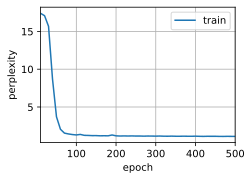

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# Load data
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# Define the bidirectional LSTM model by setting `bidirectional=True`
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# Train the model
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

由于上述原因，产出显然不能令人满意。有关更有效地使用双向 RNN 的讨论，请参阅 :numref:`sec_sentiment_rnn` 中的情绪分析应用程序。

## 摘要

* 在双向 RNN 中，每个时间步的隐藏状态由当前时间步长之前和之后的数据同时确定。
* 在概率图形模型中，双向 RNN 与前向后算法有惊人的相似之处。
* 双向 RNN 对于双向上下文的序列编码和观测值的估计非常有用。
* 由于梯度链长，双向 RNN 的训练成本非常高。

## 练习

1. 如果不同的方向使用不同数量的隐藏单位，$\mathbf{H}_t$ 的形状将如何改变？
1. 设计一个带有多个隐藏层的双向 RNN。
1. Polysemy 在自然语言中很常见。例如，“银行” 一词在 “我去银行存款” 和 “我去银行坐下来” 的上下文中有不同的含义。我们如何设计一个神经网络模型，以便在给定上下文序列和一个单词的情况下，返回上下文中单词的矢量表示形式？处理多重体学时首选哪种类型的神经体系结构？


[Discussions](https://discuss.d2l.ai/t/1059)
